In [88]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from helpers import Domain, calculate_pressure
from load_data import get_fit_params_from_pdbshot, load_single_pulse_struct, PulseStruct, KineticProfileStruct, SignalStruct
import pickle
from dataclasses import dataclass 
import scienceplots 
plt.style.use(['grid', 'science'])


In [96]:
LOCAL_SAVE_DIR = "/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs"
JET_PDB_DIR    = "/scratch/project_2009007/stability_fun/data" 
LOCAL_SAVE_DIR = "/home/akadam/EUROfusion/2024/pedestal_transport/models/data_driven/outputs"
JET_PDB_DIR    = "/home/akadam/EUROfusion/2024/data"
BASE_PULSE_DIR = JET_PDB_DIR
figure_savedir = "/home/akadam/EUROfusion/2024/pedestal_transport/models/data_driven/figures"



In [6]:


@dataclass
class Configuration: 
    shot_num: int 
    C_CRASH: float 
    C_GROWTH: float 
    mode: int 
    loc_C_growth: float = 0.0 
    loc_C_crash: float = 0.0 
    random_seed: int = 0 
    alpha_crit:  float = 0.0

@dataclass 
class Result: 
    all_ne: np.ndarray 
    all_te: np.ndarray 
    all_pe: np.ndarray 
    all_times: np.ndarray 
    all_alpha: np.ndarray
    xdomain: Domain 
    config: Configuration = None  

def load_result(savedir: str) -> Result: 
    all_ne = np.load(os.path.join(savedir, "ne.npy"))
    all_te = np.load(os.path.join(savedir, "te.npy"))
    all_pe = np.load(os.path.join(savedir, "pe.npy"))
    all_times = np.load(os.path.join(savedir, "times.npy"))
    with open(os.path.join(savedir, 'domain.pickle'), 'rb') as file: 
        xdomain = pickle.load(file)

    in_ped = xdomain.phi_norm > 0.93
    all_alpha = np.max(abs(np.gradient(all_pe[:, in_ped], xdomain.phi_norm[in_ped], axis=1)), axis=1)

    if os.path.exists(os.path.join(savedir, 'input_parameters.txt')): 
        with open(os.path.join(savedir, 'input_parameters.txt'), 'r') as f: 
            shot_num = int(f.readline().split(':')[-1])
            C_CRASH  = float(f.readline().split(':')[-1])
            C_GROWTH  = float(f.readline().split(':')[-1])
            mode     = int(f.readline().split(':')[-1])

            if mode == 0:
                LOC_GROWTH = LOC_CRASH = 0.0
            else:
                C_GROWTH  = float(f.readline().split(':')[-1]) 
                C_CRASH  = float(f.readline().split(':')[-1])
                LOC_GROWTH = float(f.readline().split(':')[-1])
                LOC_CRASH = float(f.readline().split(':')[-1])
                mode = int(mode)
            seed = f.readline().split(':')[-1]
            if seed == ' N/A\n': 
                seed = 0 
            else: 
                seed = int(seed)
            alpha_crit = f.readline().split(':')[-1]
            if alpha_crit == '': 
                alpha_crit = 114.7
            else: 
                alpha_crit = float(alpha_crit)
        config = Configuration(shot_num, C_CRASH, C_GROWTH, mode, LOC_GROWTH, LOC_CRASH, seed, alpha_crit)

    else: 
        config = None

    
    return Result(all_ne, all_te, all_pe, all_times, all_alpha, xdomain, config=config)

In [7]:
shot_num = 83624

if shot_num == 83630: 
    ALPHA_CRIT = 114.7
    expected_exp = 0.0442
elif shot_num == 83625: 
    ALPHA_CRIT = 110.0
elif shot_num == 83628:
    ALPHA_CRIT = 101.7 
    expected_exp = 0.029
elif shot_num == 83624: 
    ALPHA_CRIT = 95.46
    offset = 0.046
    expected_exp = 0.02792
else: 
    ALPHA_CRIT = 100.0
    expected_exp = 0.3
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)

savedir = os.path.join(os.path.join(LOCAL_SAVE_DIR, f'{shot_num}'))
fixed_res = load_result(savedir)
probablistic_dirs = [os.path.join(savedir, _dir) for _dir in os.listdir(savedir) if 'probabilistic' in _dir]

# savedir = os.path.join(savedir, 'probabilistic')
# savedir = "/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs/83628/probabilistic_2241206299"
savedir = probablistic_dirs[0]
prob_res_many = []
for savedir in probablistic_dirs: 
    if not os.path.exists(os.path.join(savedir,  "ne.npy")): 
        continue 
    prob_res = load_result(savedir)
    prob_res_many.append(prob_res)

te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)
from scipy.signal import find_peaks
normed_tbeo = (pulse.tbeo.data - pulse.tbeo.data.mean() ) / pulse.tbeo.data.std()


delta_t = pulse.tbeo.time[1] - pulse.tbeo.time[0]
distance_between_elms = int(200E-6 / delta_t)*20
threshold_height = normed_tbeo.std()*2

peaks, _ = find_peaks(normed_tbeo, height=threshold_height, distance=distance_between_elms)
adjusted_peaks = np.empty_like(peaks)
# TODO: SHIFT THE TBEO SIGNAL BY SOME TIME 
for i, pk in enumerate(peaks): 
    for k in range(30): 
        if normed_tbeo[pk - k] < 0: 
            zero_crossing = pk-k +1
            break 
        else: 
            zero_crossing = pk 
    adjusted_peaks[i] = zero_crossing

# peaks -= 8
elm_times = pulse.tbeo.time[peaks] # - 500E-6
tau_interelms_from_expdata = []
for i in range(len(elm_times) - 1): 
    tau_interelms_from_expdata.append(elm_times[i+1] - elm_times[i])

elm_frequencies_exp_data = 1.0 / np.array(tau_interelms_from_expdata)

t_minus_t_elm = np.empty(len(relevant_profiles.hrts_times))

for i, t in enumerate(relevant_profiles.hrts_times):
    nearest_elm_idx = np.argmin(np.abs(elm_times - t))
    t_nearest_elm = elm_times[nearest_elm_idx]    
    t_minus_t_elm[i] = t - t_nearest_elm
    

In [29]:
te_ped_idx = np.argmin(abs(fixed_res.xdomain.phi_norm - (te_fit_params.p - te_fit_params.w)))
ne_ped_idx = np.argmin(abs(fixed_res.xdomain.phi_norm - (ne_fit_params.p - ne_fit_params.w)))

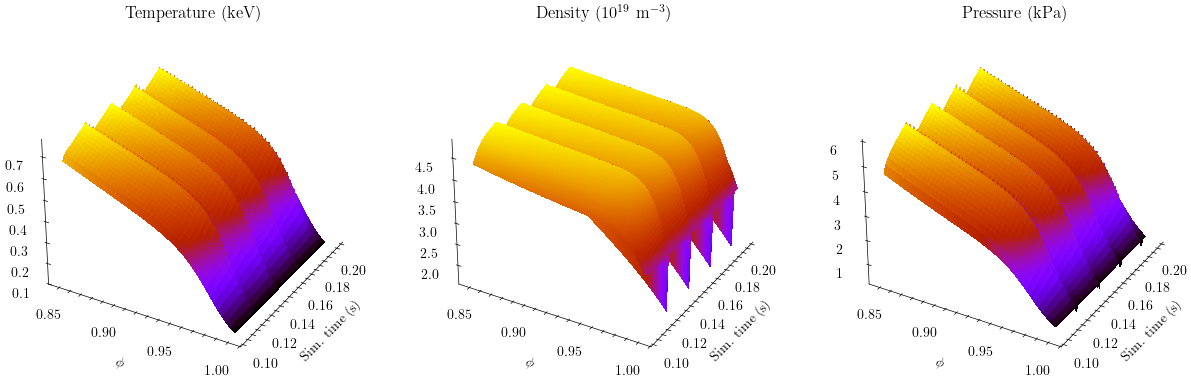

In [97]:
# 3D plot of fixed result: z-axis is density, x-axis is phi_norm, y-axis is time 

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# max_ne = np.max(fixed_res.all_ne[:, ne_ped_idx])
# min_ne = np.min(fixed_res.all_ne[:, ne_ped_idx])
# for i in range(len(fixed_res.all_times)): 
#     if fixed_res.all_times[i] > 0.1: 
#         break 
#     # color based on the pedestal temperature maximum and minimum 
#     color = plt.cm.viridis((fixed_res.all_ne[i, ne_ped_idx] - min_ne) / (max_ne - min_ne))
#     ax.plot(fixed_res.xdomain.phi_norm, fixed_res.all_times[i]*np.ones_like(fixed_res.xdomain.phi_norm), fixed_res.all_ne[i], color=color)
#     # ax.plot(fixed_res.xdomain.phi_norm, fixed_res.all_times[i]*np.ones_like(fixed_res.xdomain.phi_norm), fixed_res.all_te[i], color='r', alpha=0.5)
#     # ax.plot(fixed_res.xdomain.phi_norm, fixed_res.all_times[i]*np.ones_like(fixed_res.xdomain.phi_norm), fixed_res.all_pe[i], color='g', alpha=0.5) 
# plt.show()
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Do same but with meshgrid 
ped_region = fixed_res.xdomain.phi_norm > 0.85
time_domain = np.logical_and(fixed_res.all_times > 0.1, fixed_res.all_times < 0.2)
min_ne, max_ne = np.min(fixed_res.all_ne[:, ped_region][time_domain]), np.max(fixed_res.all_ne[:, ped_region][time_domain])
# min_te, max_te = np.min(fixed_res.all_te[time_domain, ped_region]), np.max(fixed_res.all_te[time_domain, ped_region])
# min_pe, max_pe = np.min(fixed_res.all_pe[time_domain, ped_region]), np.max(fixed_res.all_pe[time_domain, ped_region])

def remove_borders(an_ax): 
    an_ax.grid(False)  # Turn off grid
    an_ax.xaxis.pane.fill = False  # Turn off background pane
    an_ax.yaxis.pane.fill = False  # Turn off background pane
    an_ax.zaxis.pane.fill = False  # Turn off background pane
    an_ax.xaxis.pane.set_edgecolor('w')  # Remove pane borders
    an_ax.yaxis.pane.set_edgecolor('w')
    an_ax.zaxis.pane.set_edgecolor('w')
    an_ax.zaxis.label.set_position((1.1, 0))  # Adjust the position of the label to be in front-left
    an_ax.zaxis._axinfo['juggled'] = (1, 2, 0)  # Reorder the axis planes to bring z to the front-left

X, Y = np.meshgrid(fixed_res.xdomain.phi_norm[ped_region], fixed_res.all_times[time_domain])
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d')


remove_borders(ax)
cm = ax.plot_surface(X, Y, fixed_res.all_te[:, ped_region][time_domain], cmap='gnuplot', antialiased=False)
ax.set_zlabel(r'$T$ (keV)')
# fig.colorbar(cm, ax=ax, shrink=0.6)
ax1 = fig.add_subplot(132, projection='3d')
remove_borders(ax1)
ne_plane = fixed_res.xdomain.phi_norm[ne_ped_idx]
y_plane =  np.linspace(Y.min(), Y.max())
z_plane = np.linspace(min_ne, max_ne - 0.5)
Yp, Zp = np.meshgrid(y_plane, z_plane)
# ax1.plot_surface(ne_plane*np.ones_like(Yp), Yp, Zp, color='grey', alpha=0.3, zorder=-1)
ax1.plot_surface(X, Y, fixed_res.all_ne[:, ped_region][time_domain], cmap='gnuplot', antialiased=False, rstride=1, cstride=1, vmin=min_ne, vmax=max_ne, zorder=5)

ax2 = fig.add_subplot(133, projection='3d')
remove_borders(ax2)

ax2.plot_surface(X, Y, fixed_res.all_pe[:, ped_region][time_domain], cmap='gnuplot', antialiased=False)
ax2.set_title(r'Pressure (kPa)')
ax1.set_title(r'Density ($10^{19}$ m$^{-3}$)')
ax.set_title(r'Temperature (keV)')
ax.set_zlabel('keV')
for axs in [ax, ax1, ax2]: 
    axs.set_xlabel(r'$\phi$')
    axs.set_ylabel(r'Sim. time (s)')
    axs.set_xticks([0.85, 0.9, 0.95, 1.0])

fname = os.path.join(figure_savedir, f'{shot_num}_fixed_results.png')
# plt.savefig(fname, dpi=300, transparent=True)
plt.show()

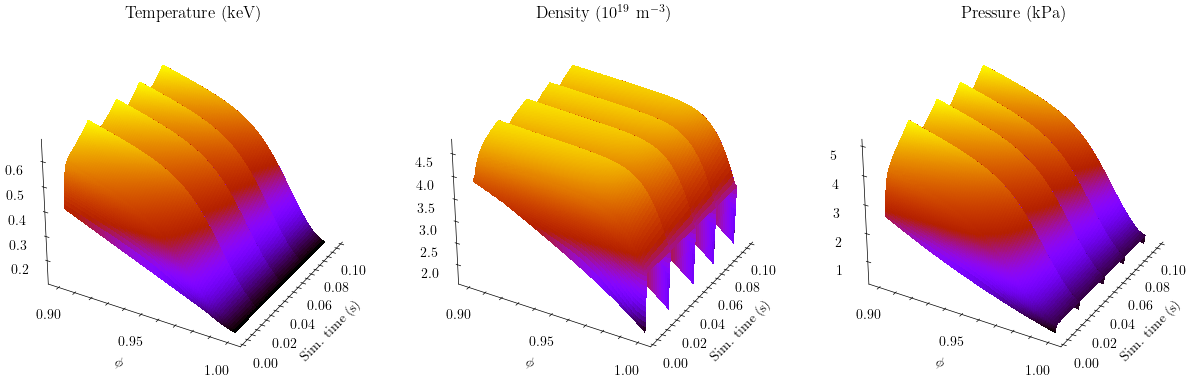

In [112]:
def plot_3d_res(res: Result): 
    ped_region = res.xdomain.phi_norm > 0.9
    time_domain = np.logical_and(res.all_times > 0.0, res.all_times < 0.1)
    X, Y = np.meshgrid(res.xdomain.phi_norm[ped_region], res.all_times[time_domain])
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(131, projection='3d')

    remove_borders(ax)
    cm = ax.plot_surface(X, Y, res.all_te[:, ped_region][time_domain], cmap='gnuplot', antialiased=False, rstride=1, cstride=1)
    ax.set_zlabel(r'$T$ (keV)')
    ax1 = fig.add_subplot(132, projection='3d')
    remove_borders(ax1)
    ne_plane = res.xdomain.phi_norm[ne_ped_idx]
    y_plane =  np.linspace(Y.min(), Y.max())
    z_plane = np.linspace(min_ne, max_ne - 0.5)
    Yp, Zp = np.meshgrid(y_plane, z_plane)
    ax1.plot_surface(X, Y, res.all_ne[:, ped_region][time_domain], cmap='gnuplot', antialiased=False, rstride=1, cstride=1, vmin=min_ne, vmax=max_ne, zorder=5)

    ax2 = fig.add_subplot(133, projection='3d')
    remove_borders(ax2)

    ax2.plot_surface(X, Y, res.all_pe[:, ped_region][time_domain], cmap='gnuplot', antialiased=False, rstride=1, cstride=1)
    ax2.set_title(r'Pressure (kPa)')
    ax1.set_title(r'Density ($10^{19}$ m$^{-3}$)')
    ax.set_title(r'Temperature (keV)')
    ax.set_zlabel('keV')
    for axs in [ax, ax1, ax2]: 
        axs.set_xlabel(r'$\phi$')
        axs.set_ylabel(r'Sim. time (s)')
        axs.set_xticks([0.9, 0.95, 1.0])

    fname = os.path.join(figure_savedir, f'{shot_num}_results_{res.config.random_seed}.png')
    # plt.savefig(fname, dpi=300, transparent=True)
    plt.show()

for n, prob_res in enumerate(prob_res_many): 
    if prob_res.config.mode != 2: 
        continue 
    plot_3d_res(prob_res)
    break 

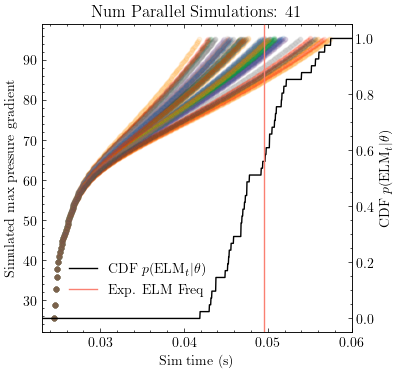

In [103]:
from scipy.interpolate import interp1d
fig, axs = plt.subplots(1, 1, figsize=(4, 4)) 

axs.grid(False)
time_elm_crash = []

interpreted_t = np.linspace(1/40.0, 0.06, 1000)
interpreted_vals = []
for n, prob_res in enumerate(prob_res_many): 
    if prob_res.config.mode != 2: 
        continue 
    elm_events = prob_res.all_alpha >= ALPHA_CRIT
    elm_idxs   = np.argwhere(elm_events == True)[:-1, 0]
    start, stop = elm_idxs[0] +1, elm_idxs[1]
    axs.scatter(prob_res.all_times[start:stop], prob_res.all_alpha[start:stop], alpha=0.1, s=10)
    f_interp = interp1d(prob_res.all_times[start:stop], prob_res.all_alpha[start:stop], bounds_error=False)
    interpreted_vals.append(f_interp(interpreted_t))
    
    time_elm_crash.append(prob_res.all_times[stop])

interpreted_vals = np.stack(interpreted_vals, 0)
# print(interpreted_t.max())
# axs.plot(interpreted_t, interpreted_vals.mean(0))

# print(prob_res.all_times[start], 1/40.0)
time_elm_crash = sorted(time_elm_crash)
t_next_elm   = np.linspace(0.023, 0.06, 1000)
p_of_nex_elm = np.zeros_like(t_next_elm)
for t in time_elm_crash:
    where_greater = t_next_elm > t 
    p_of_nex_elm[where_greater] += 1
p_of_nex_elm /= len(time_elm_crash)


axsprob = axs.twinx()
axsprob.grid(False)
axsprob.plot(t_next_elm, p_of_nex_elm, color='black', label=r'CDF $p(\text{ELM}_t | \theta)$')
axsprob.axvline(1.0 / 40.0 + prob_res.all_times[start], color='salmon', label='Exp. ELM Freq')
axsprob.legend(loc=(0.07, 0.1))
axs.set_ylabel('Simulated max pressure gradient')
axsprob.set_ylabel(r'CDF $p(\text{ELM}_t| \theta)$')
axs.set_xlim(0.023, 0.06)
axs.set_title(f'Num Parallel Simulations: {len(time_elm_crash)}')
axs.set_xlabel('Sim time (s)')
savename = os.path.join(figure_savedir, f'{shot_num}_probabilistic_results.png')
plt.savefig(savename, dpi=300, transparent=True)
plt.show()

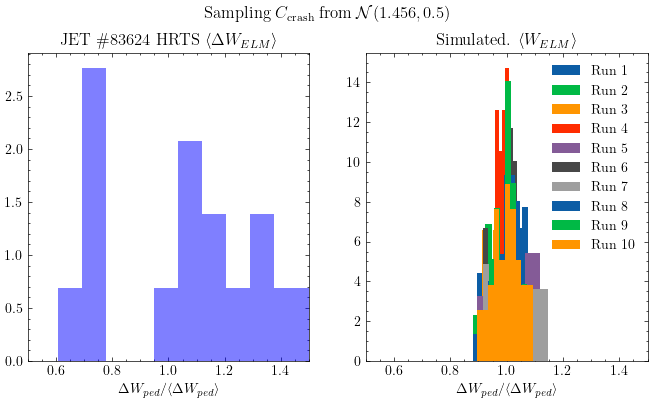

In [124]:
# Stored energy plot 
from scipy.integrate import simpson 

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# Check for config.mode == 3
p = 1
for n, prob_res in enumerate(prob_res_many): 
    if prob_res.config.mode not in [1, 3]: 
        continue 
    elm_events = prob_res.all_alpha >= ALPHA_CRIT
    elm_idxs   = np.argwhere(elm_events == True)[:-1, 0]
    pre_elm_idxs = elm_idxs 
    post_elm_idxs = elm_idxs + 1
    change_in_stored_energies = np.empty(len(pre_elm_idxs))
    for k, (pre, post) in enumerate(zip(pre_elm_idxs, post_elm_idxs)): 
        stored_energy_prelm = simpson(prob_res.all_pe[pre], x=prob_res.xdomain.phi_norm)
        stored_energy_post_elm = simpson(prob_res.all_pe[post], x=prob_res.xdomain.phi_norm)
        delta_w = stored_energy_prelm-stored_energy_post_elm
        change_in_stored_energies[k] = delta_w
    axs[1].hist(change_in_stored_energies / np.mean(change_in_stored_energies), stacked=True, label=f'Run {p}', density=True)
    if p >= 10: 
        break 
    p += 1
    
pre_elm_stored_energy = 0.0016
change_in_stored_energies_exp = []
for i, t in enumerate(t_minus_t_elm): 
    pedestal_region = (relevant_profiles.hrts_psi[i] + offset) > 0.90
    inside_sep      = np.logical_and((relevant_profiles.hrts_psi[i] + offset) > 0.7, (relevant_profiles.hrts_psi[i] + offset) < 1.0)
    pressure_all = calculate_pressure(relevant_profiles.te[i]*1E-3, relevant_profiles.ne[i]*1E-19)*1000.0
    pressure_ped = calculate_pressure(relevant_profiles.te[i, inside_sep]*1E-3, relevant_profiles.ne[i, inside_sep]*1E-19)*1000.0
    # stored_energy = trapezoid(pressure) * 1E-6 # , x=relevant_profiles.hrts_psi[i, inside_sep] + offset in MJ
    # axs[3].scatter(t*1000, stored_energy, color='black')
    stored_energy_all = simpson(pressure_all, x=relevant_profiles.hrts_psi[i] + offset) * 1E-6 # ,  in MJ
    stored_energy_ped = simpson(pressure_ped, x=relevant_profiles.hrts_psi[i, inside_sep] + offset) * 1E-6 # ,  in MJ
    frac_stored_energy = stored_energy_ped / stored_energy_all
    if t*1000 > 0.0 and t*1000 < 5.0:#  and stored_energy_ped < pre_elm_stored_energy:
        change_in_stored_energies_exp.append(pre_elm_stored_energy- stored_energy_ped)
change_in_stored_energies_exp = np.array(change_in_stored_energies_exp)
axs[0].hist(change_in_stored_energies_exp / np.mean(change_in_stored_energies_exp), bins=20, color='blue', alpha=0.5, density=True)
axs[1].legend()
axs[1].set_xlabel(r'$\Delta W_{ped} / \langle \Delta W_{ped} \rangle$')
for ax in axs: 
    ax.set_xlim(0.5, 1.5)
    ax.set_xlabel(r'$\Delta W_{ped} / \langle \Delta W_{ped} \rangle$')
    ax.grid(False)
axs[0].set_title(f'JET  \#{shot_num} HRTS ' + r'$\langle \Delta W_{ELM} \rangle $')
axs[1].set_title(r'Simulated. $\langle W_{ELM} \rangle $')

fig.suptitle(r'Sampling $C_\text{crash} \; \text{from} \; \mathcal{N}(1.456, 0.5)$', y=1.0)

savename = os.path.join(figure_savedir, f'{shot_num}_ccrash_sample_scan.png')
fig.savefig(savename, dpi=300, transparent=True)
plt.show()

In [48]:
te_ped_idx = np.argmin(abs(fixed_res.xdomain.phi_norm - (te_fit_params.p - te_fit_params.w)))
ne_ped_idx = np.argmin(abs(fixed_res.xdomain.phi_norm - (ne_fit_params.p - ne_fit_params.w)))

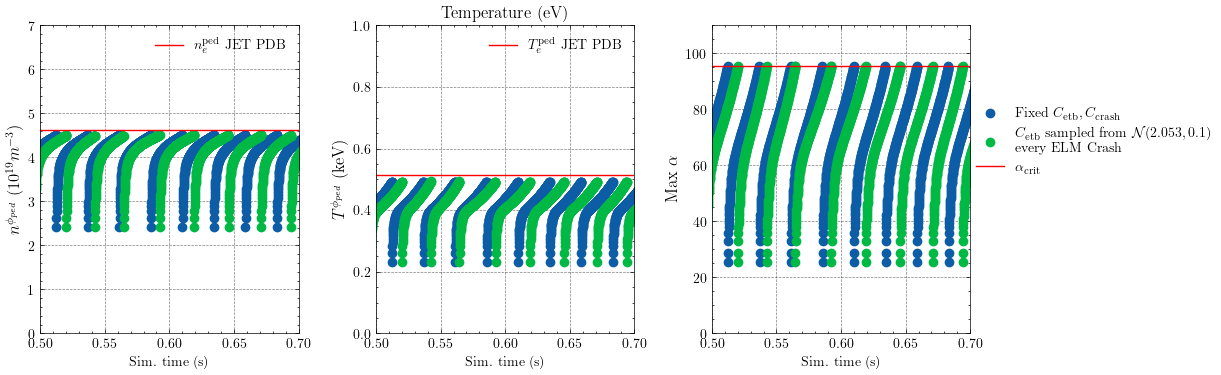

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(fixed_res.all_times, fixed_res.all_ne[:, ne_ped_idx])
axs[1].scatter(fixed_res.all_times, fixed_res.all_te[:, te_ped_idx + 20])
axs[2].scatter(fixed_res.all_times, fixed_res.all_alpha, label=r'Fixed $C_\text{etb}, C_\text{crash}$')
p = 0
for n, prob_res in enumerate(prob_res_many):
    if n in [1, 2, 7, 10] or prob_res.all_times.max() < 0.3 or prob_res.config.mode != 2: 
        continue 
    p += 1 
    if p != 2: 
        continue 
    axs[0].scatter(prob_res.all_times, prob_res.all_ne[:, ne_ped_idx])
    axs[1].scatter(prob_res.all_times, prob_res.all_te[:, te_ped_idx + 20])
    axs[2].scatter(prob_res.all_times, prob_res.all_alpha, label=r'$C_\text{etb}$ sampled from $\mathcal{N}(2.053, 0.1)$' + '\n every ELM Crash')
    
axs[1].axhline(te_fit_params.h1, color='red', label=r'$T_e^\text{ped}$ JET PDB')
axs[0].axhline(ne_fit_params.h1, color='red', label=r'$n_e^\text{ped}$ JET PDB')
    
axs[0].set_ylabel(r'$n^{\phi_{ped}}$  ($10^{19} m^{-3}$)', fontsize=12)# set_ylabel('ne @ pedestal')
axs[1].set_ylabel(r'$T^{\phi_{ped}}$ (keV)', fontsize=12)
axs[2].set_ylabel(r'Max $\alpha$', fontsize=12)
axs[1].legend()
axs[0].legend()
for ax in axs: 
    ax.set_xlabel('Sim. time (s)')
    ax.set_xlim(0.5, 0.7)
axs[2].axhline(ALPHA_CRIT, color='red', label=r'$\alpha_\text{crit}$')
axs[2].legend(loc=(1.00, 0.5))
axs[0].set_ylim(0, 7.)
axs[1].set_ylim(0, 1.0)
axs[2].set_ylim(0, 110)
axs[0].set_label('Density (m$^-3$)')
axs[1].set_title('Temperature (eV)')
fig.subplots_adjust(wspace=0.3)
savename = os.path.join(figure_savedir, f'{shot_num}_etb_sample_timevolve.png')
fig.savefig(savename, dpi=300, transparent=True)
plt.show()

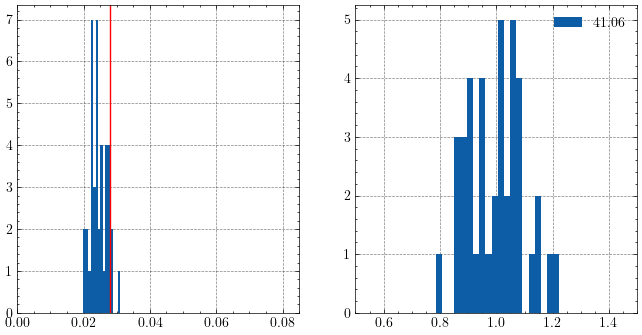

In [115]:
def get_tau_interelms(res: Result) -> np.ndarray: 
    elm_events = res.all_alpha >= ALPHA_CRIT
    elm_times  = res.all_times[elm_events]
    tau_interelms = np.empty(len(elm_times) -1)
    for i in range(len(elm_times)-1): 
        tau_interelms[i] = elm_times[i+1] - elm_times[i]
    return tau_interelms

prob_res = prob_res_many[1]

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

tau_interelms_all = []
for prob_res in prob_res_many: 
    TAU_INTERELM = get_tau_interelms(prob_res)
    axs[0].hist(TAU_INTERELM, bins=15)
    frequencies = 1.0 / TAU_INTERELM
    axs[1].hist(frequencies / np.mean(frequencies), label=f'{np.mean(frequencies):.4}', bins=20)
    print()
    tau_interelms_all.append(TAU_INTERELM)
    break

FIXED_TAU_INTERELM = get_tau_interelms(fixed_res)
# axs[0].axvline(FIXED_TAU_INTERELM.mean(), label=f'{FIXED_TAU_INTERELM.mean():.4}')
axs[0].axvline(expected_exp, color='red')
axs[0].set_xlim(0.0, 0.085)
axs[1].legend()
axs[1].set_xlim(0.5, 1.5)
# print((prob_res.all_alpha >= ALPHA_CRIT).sum())
plt.show()


1.0082999999999054 0 2
1.0135999999999048 3 2
1.0164999999999045 14 2
1.0128999999999049 16 2
1.0160999999999045 18 2


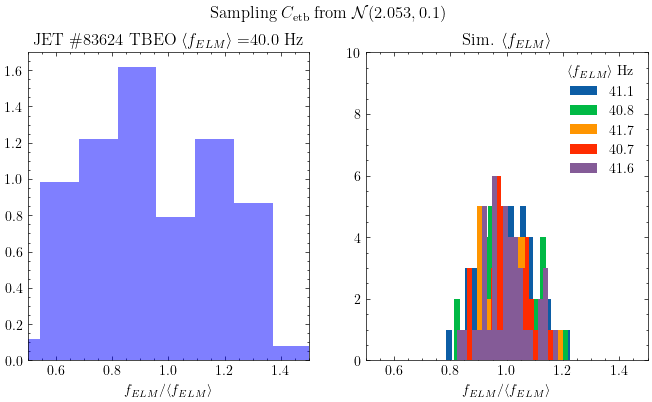

In [147]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))


p = 0
axs[0].hist(elm_frequencies_exp_data / np.mean(elm_frequencies_exp_data), bins=20, color='blue', alpha=0.5, density=True)
for n, prob_res in enumerate(prob_res_many): 
    tau_interelm_sim = get_tau_interelms(prob_res)
    # if (prob_res.all_times.max() < 0.3) or (np.mean(elm_frequencies_sim) > 45): 
    #     continue 
    if n in [1, 2, 7, 10] or prob_res.all_times.max() < 0.3 or prob_res.config.mode != 2: 
        continue 

    elm_frequencies_sim = 1.0 / tau_interelm_sim
    axs[1].hist(elm_frequencies_sim / np.mean(elm_frequencies_sim), bins=20, label=f'{np.mean(elm_frequencies_sim):.1f}')
    p += 1
    print(prob_res.all_times.max(), n, prob_res.config.mode)
    if p > 4: 
        break 

axs[0].set_title(f'JET  \#{shot_num} TBEO ' + r'$\langle f_{ELM} \rangle = $' + f'{np.mean(elm_frequencies_exp_data):.1f} Hz')
axs[1].set_title(r'Sim. $\langle f_{ELM} \rangle$')
axs[1].legend(title=r'$\langle f_{ELM} \rangle$' + ' Hz')
axs[1].set_ylim(0, 10)
for ax in axs: 
    ax.set_xlim(0.5, 1.5)
    ax.set_xlabel(r'$f_{ELM} / \langle f_{ELM} \rangle$')
    ax.grid(False)

fig.suptitle(r'Sampling $C_\text{etb} \; \text{from} \; \mathcal{N}(2.053, 0.1)$', y=1.0)
savename = os.path.join(figure_savedir, f'{shot_num}_cetb_sample_scan.png')
fig.savefig(savename, dpi=300, transparent=True)
plt.show()

    